## Introduction

The purpose of this project is to carry out NLP analysis of Donald Trump's political rally speeches. <br> Our goal is to identify any characteristic features of these speeches, and to determine if there is any relationships between the nature of the speech and the time and place it was given.

## Import Libraries

In [61]:
#Import libraries for text import
import glob
import os

#Import libraries for generating word clouds
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt

#Import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Import libraries for developing database 
import pandas as pd
import numpy as np
from datetime import datetime
import re
import geopandas as gpd
import geoplot

#Import libraries for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.collocations import *

In [2]:
#remove warning messages that reduce readability
import warnings
warnings.filterwarnings("ignore")

## Import Text Data

In [3]:
#Save speech data separated by rally
list_of_speech = []
list_of_rally = []

#Generate corpus using all speeches
corpus = ""

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        print(file_path)
        text = open(file_path,'r').read()
        list_of_speech.append(text)
        rallyname = (file_path.rsplit('/', 1)[-1])[:-4]
        list_of_rally.append(rallyname)
        corpus = corpus + text

## Reference: Abdelkader Rhouati[https://www.kaggle.com/arhouati/analysis-of-trump-speech-what-he-talk-about]
## Reference: Nitesh Halai[https://www.kaggle.com/niteshhalai/donald-trump-s-rallies-nlp]

/kaggle/input/donald-trumps-rallies/NewHampshireAug15_2019.txt
/kaggle/input/donald-trumps-rallies/BattleCreekDec19_2019.txt
/kaggle/input/donald-trumps-rallies/LasVegasFeb21_2020.txt
/kaggle/input/donald-trumps-rallies/MilwaukeeJan14_2020.txt
/kaggle/input/donald-trumps-rallies/FreelandSep10_2020.txt
/kaggle/input/donald-trumps-rallies/LexingtonNov4_2019.txt
/kaggle/input/donald-trumps-rallies/OhioSep21_2020.txt
/kaggle/input/donald-trumps-rallies/FayettevilleSep19_2020.txt
/kaggle/input/donald-trumps-rallies/HendersonSep13_2020.txt
/kaggle/input/donald-trumps-rallies/GreenvilleJul17_2019.txt
/kaggle/input/donald-trumps-rallies/MindenSep12_2020.txt
/kaggle/input/donald-trumps-rallies/FayettevilleSep9_2019.txt
/kaggle/input/donald-trumps-rallies/PittsburghSep22_2020.txt
/kaggle/input/donald-trumps-rallies/DesMoinesJan30_2020.txt
/kaggle/input/donald-trumps-rallies/HersheyDec10_2019.txt
/kaggle/input/donald-trumps-rallies/ToledoJan9_2020.txt
/kaggle/input/donald-trumps-rallies/DallasOct

## Generate Dataset

We want to gain more information about his choice of words, the overall sentiment of the speeches, the key topics of speeches, if speeches differ over time and place. <br>
To do this we will generate a dataset including data regarding:
1. Date when each speech was made for when we want to evaluate speeches over time
2. Locations of the rallies to see if the city and state influence the speech
3. Frequency of words from each speech to determine the general topic
4. Overall speech sentiments to see if the tone of the speeches change over time

### Clean up Rally Data

In [4]:
#Split filename into rally location and date
elems = []
for r in list_of_rally:
    r_new = re.sub(r'\b\w{1,2}\b', '', r)
    elem = re.sub( r"([A-Z])", r" \1", r_new).split()
    elems.append(elem)

### Extract Rally Dates

In [5]:
#Create list of rally dates
dates = []

#Retrieve date info from text and add to dates list
for elem in elems:
    date = elem[-1]
    date = date.replace('_', '/') 
    date = date[0:3] + '/' + date[3:]
    dates.append(date)
    elem = elem.remove(elem[-1])
    
#Change date format from string to datetime
date_update = []
for date in dates:
    date_new = datetime.strptime(date, '%b/%d/%Y')
    date_update.append(date_new)

### Extract Rally Locations

In [6]:
#Create list of rally locations
locations = []

#Retrieve location info from text and add to locations list
for elem in elems:
    loc = ' '.join(elem)
    locations.append(loc)

### Word Count per Speech

In [32]:
#Define set of stop words for remaining analysis
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'going', 'said'])

In [33]:
#Frequency of words in each speech and remove stop words from count
speech_fdist = []
fdist = FreqDist()
for speech in list_of_speech:
    for sentence in sent_tokenize(speech):
        sentence = re.sub(r'\b\w{1,2}\b', '', sentence)
        sentence = re.sub(r'[^\w]', ' ', sentence)
        for word in word_tokenize(sentence):
            if word not in stop_words: 
                fdist[word] += 1
    speech_fdist.append(fdist)
    fdist = FreqDist()


### Speech Sentiment

In [23]:
#Initialize sentiment analyzer
sid = SentimentIntensityAnalyzer()

In [24]:
#Assign sentiment for each speech
positive_sentiment = []
negative_sentiment = []
neutral_sentiment = []

for speech in list_of_speech:
            sentiment = sid.polarity_scores(speech)
            positive_sentiment.append(sentiment['pos'])
            negative_sentiment.append(sentiment['neg'])
            neutral_sentiment.append(sentiment['neu'])

### Generate Final Dataset

In [34]:
#Generate final data frame
dict = {'Date':date_update, 'Location':locations, 'Speech': list_of_speech, 
        'Speech Word Frequency': speech_fdist, 'Positive_Sentiment':positive_sentiment, 
        'Negative_Sentiment':negative_sentiment, 'Neutral Sentiment': neutral_sentiment}  
df = pd.DataFrame(dict)

## Dataset Analysis

In [35]:
#Preview dataset
df.head()

,Date,Location,Speech,Speech Word Frequency,Positive_Sentiment,Negative_Sentiment,Neutral Sentiment
0,2019-08-15,New Hampshire,Thank you very much everybody. Thank you. Wow...,"{'Thank': 24, 'much': 17, 'everybody': 4, 'Wow...",0.189,0.090,0.721
1,2019-12-19,Battle Creek,Thank you. Thank you. Thank you to Vice Presid...,"{'Thank': 30, 'Vice': 1, 'President': 17, 'Pen...",0.146,0.103,0.751
2,2020-02-21,Las Vegas,"Well, thank you very much. And hello Las Vegas...","{'Well': 9, 'thank': 9, 'much': 21, 'And': 87,...",0.180,0.096,0.724
3,2020-01-14,Milwaukee,Well thank you very much. And I'm thrilled to ...,"{'Well': 4, 'thank': 2, 'much': 10, 'And': 83,...",0.168,0.105,0.728
4,2020-09-10,Freeland,"We brought you a lot of car plants, Michigan. ...","{'brought': 4, 'lot': 26, 'car': 6, 'plants': ...",0.177,0.097,0.727


In [36]:
#See datatypes of entries
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   35 non-null     datetime64[ns]
 1   Location               35 non-null     object        
 2   Speech                 35 non-null     object        
 3   Speech Word Frequency  35 non-null     object        
 4   Positive_Sentiment     35 non-null     float64       
 5   Negative_Sentiment     35 non-null     float64       
 6   Neutral Sentiment      35 non-null     float64       
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 2.0+ KB


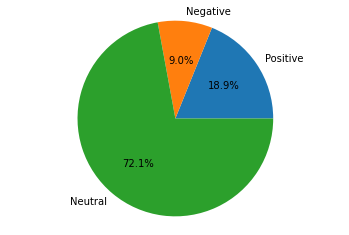

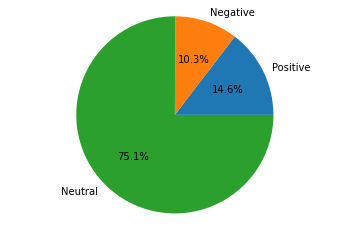

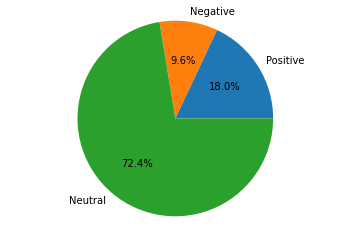

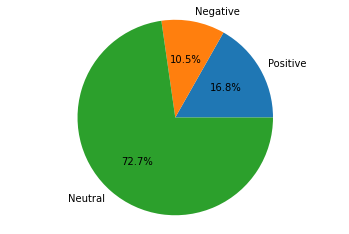

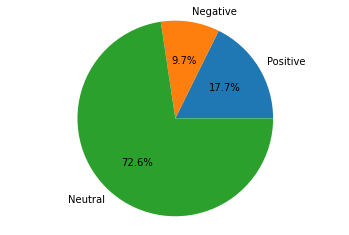

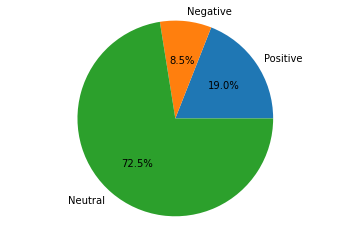

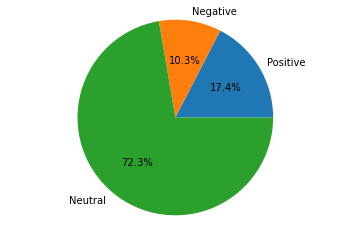

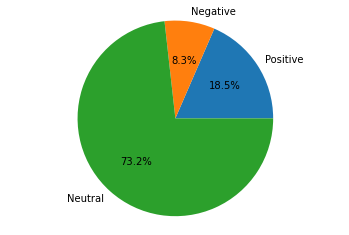

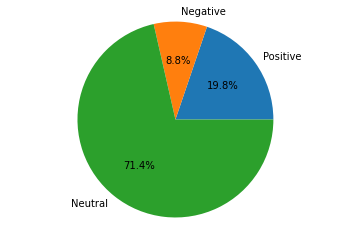

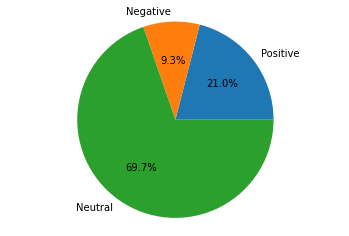

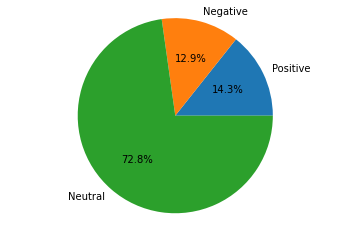

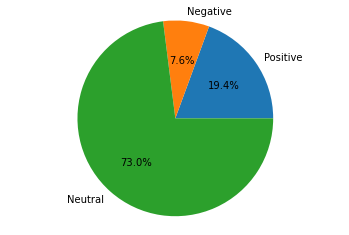

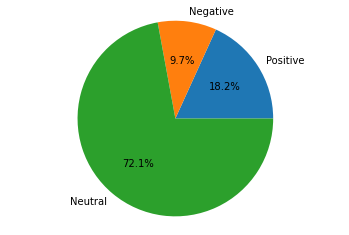

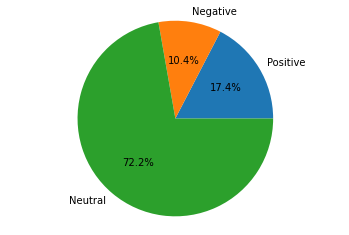

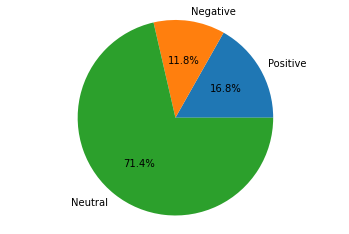

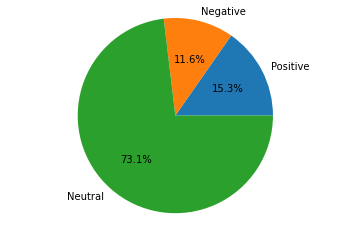

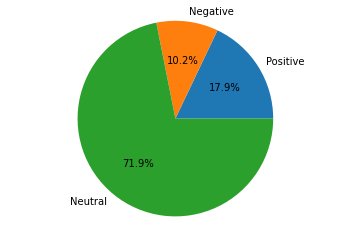

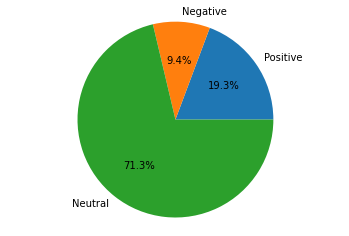

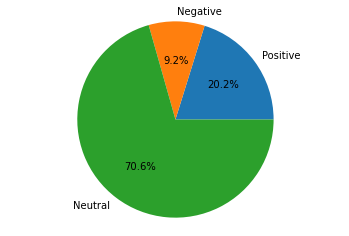

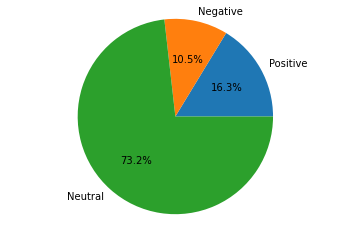

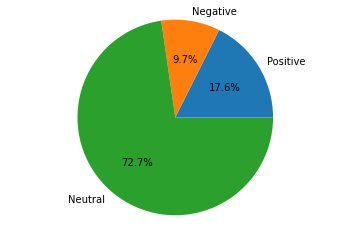

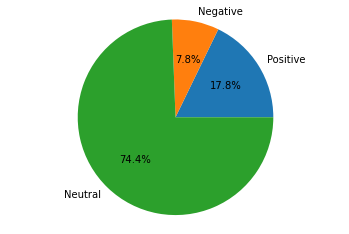

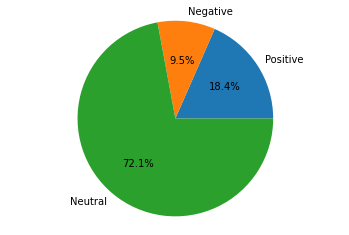

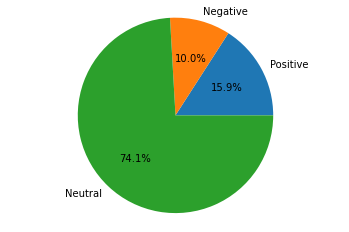

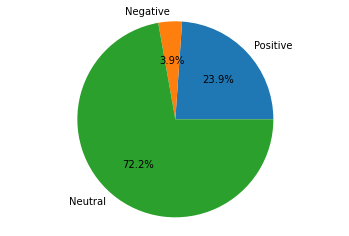

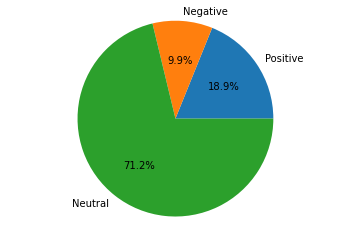

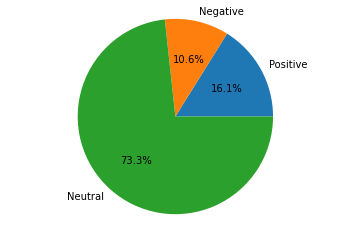

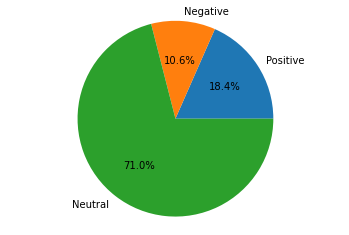

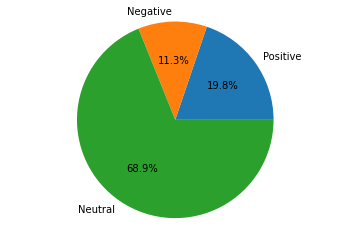

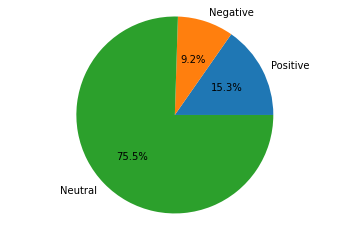

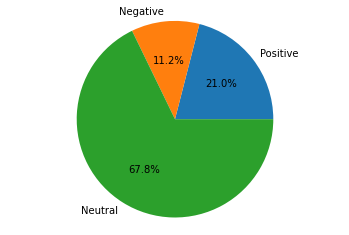

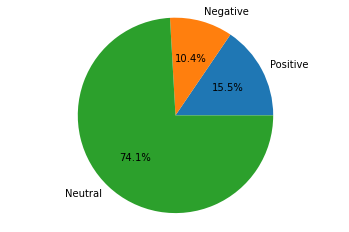

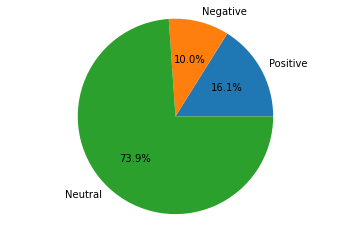

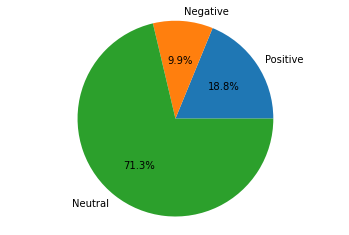

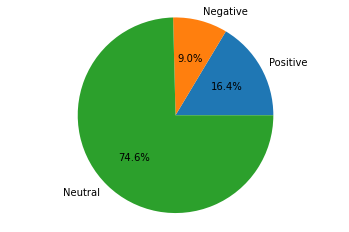

In [28]:
#Plot charts to visualize speech sentiment
labels = 'Positive', 'Negative', 'Neutral'

for i in range(len(df)) :
    pos = df.iloc[i,4] * 100
    neg = df.iloc[i,5] * 100
    neu = df.iloc[i,6] * 100
    sizes = [pos, neg, neu]
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

From this we can see that the majority of speeches have a neutral sentiment majority. This means that the choice of words in those speeches were not outright positive or negative.

## Tokenization

In [37]:
#tokenize speech text corpus
corpus_tokenize = word_tokenize(corpus)
#remove smaller insignificant texts and stop words
new_corpus_tokenize = []
for corp in corpus_tokenize:
    new_corp = re.sub(r'\b\w{1,2}\b', '', corp)
    new_corp = re.sub(r'\W+', '', new_corp)
    if new_corp not in stop_words:
        new_corpus_tokenize.append(new_corp)
    
#rejoin tokenized corpus as one text string
new_corpus_tokenize = " ".join(new_corpus_tokenize)

## Generate Word Cloud

We can start off by making a word cloud using text from all of the speeches to see if the choice and frequency of words used demonstrates anything interesting about the overall nature of his speeches.

In [38]:
#Generate word cloud from corpus (which is text from all speeches)
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, colormap='Pastel1', 
                      collocations=False, stopwords = STOPWORDS).generate(new_corpus_tokenize)

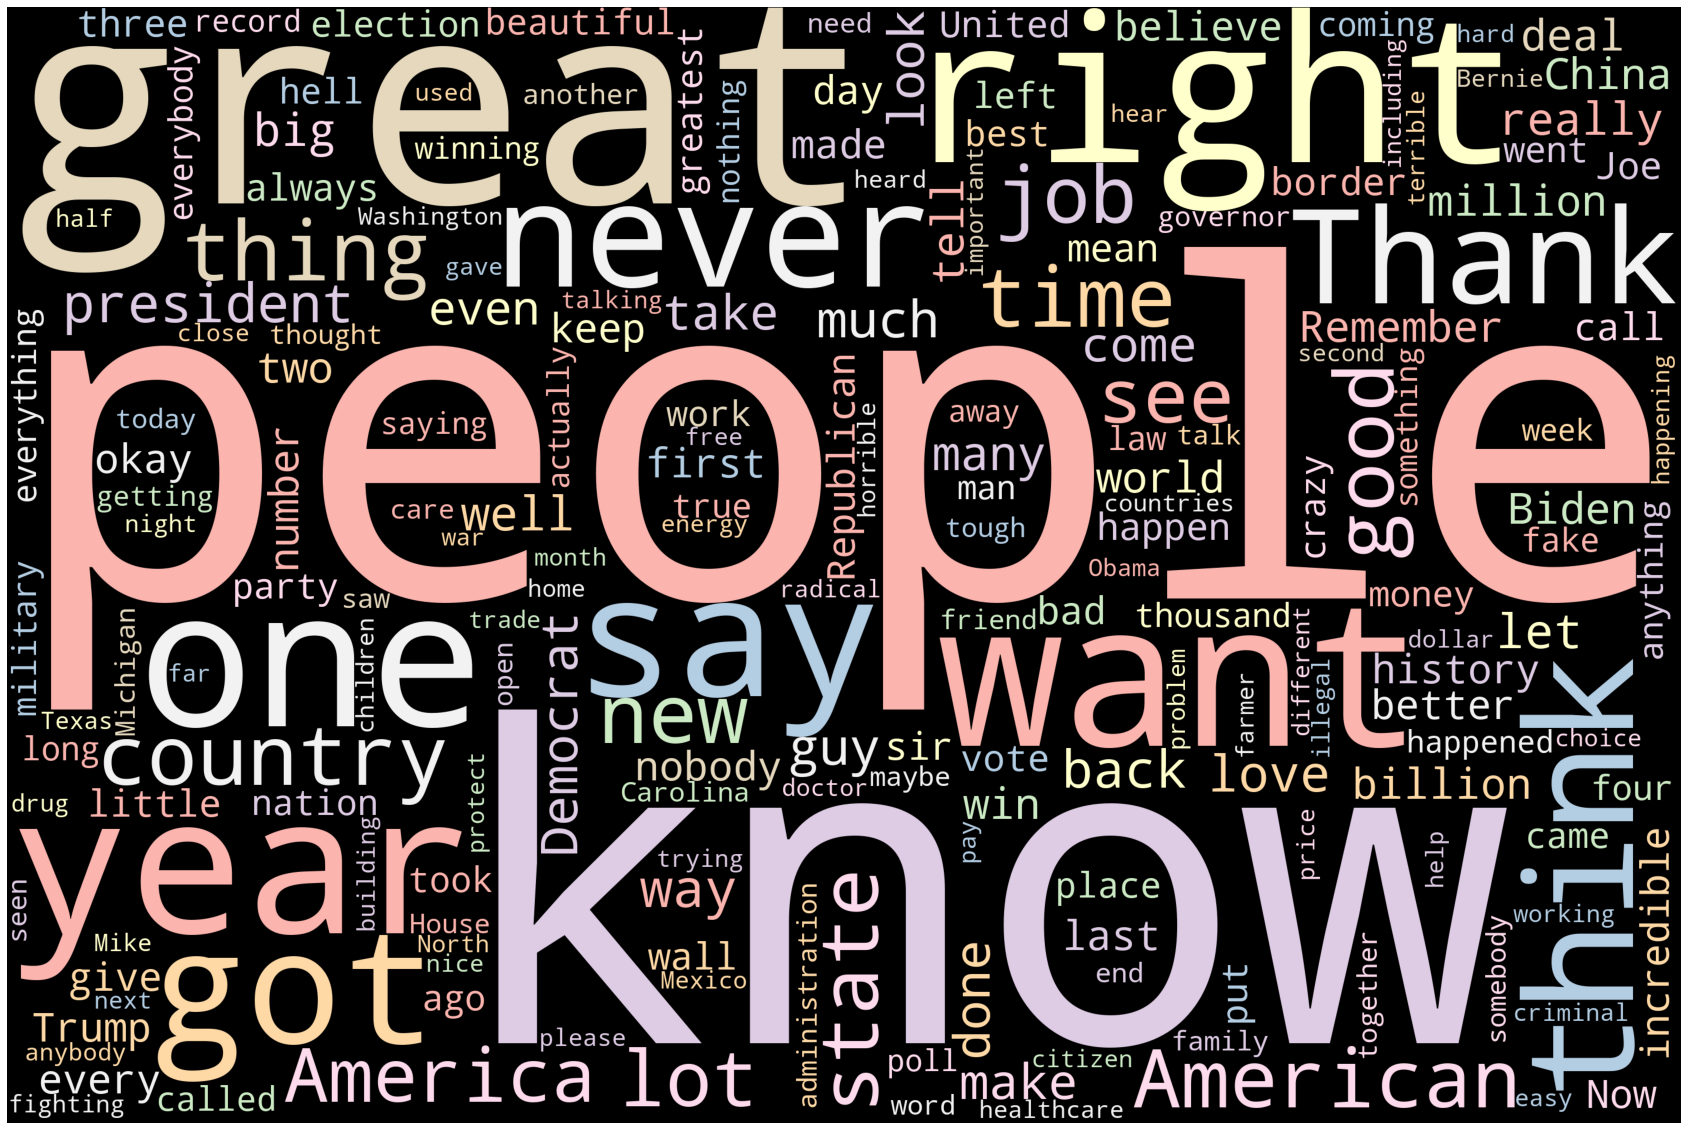

In [39]:
# Plot
plt.figure(figsize=(30,30))
plt.axis('off')
plt.imshow(wordcloud)

### Bigrams

Now we will develop some bigrams to look into common phrases from the speeches.

In [107]:
#develop bigrams for speeches
bigram_speech = []
speeches = df.Speech
for speech in speeches:
    speech = re.sub(r'\b\w{1,2}\b', '', speech)
    speech = re.sub(r'[^\w]', ' ', speech)
    speech_bigrams = (bigrams(word_tokenize(speech)))
    
#convert bigram tuples to strings
for bigram in speech_bigrams:
    bigram = ' '.join(bigram) 
    bigram_speech.append(bigram)

In [116]:
#get frequecy of word-pairs
bi_grams_freq = FreqDist(bigram_speech)
mostCommonBigrams= bi_grams_freq.most_common(30)

bigram = [bigram[0] for bigram in mostCommonBigrams]
count = [bigram[1] for bigram in mostCommonBigrams]

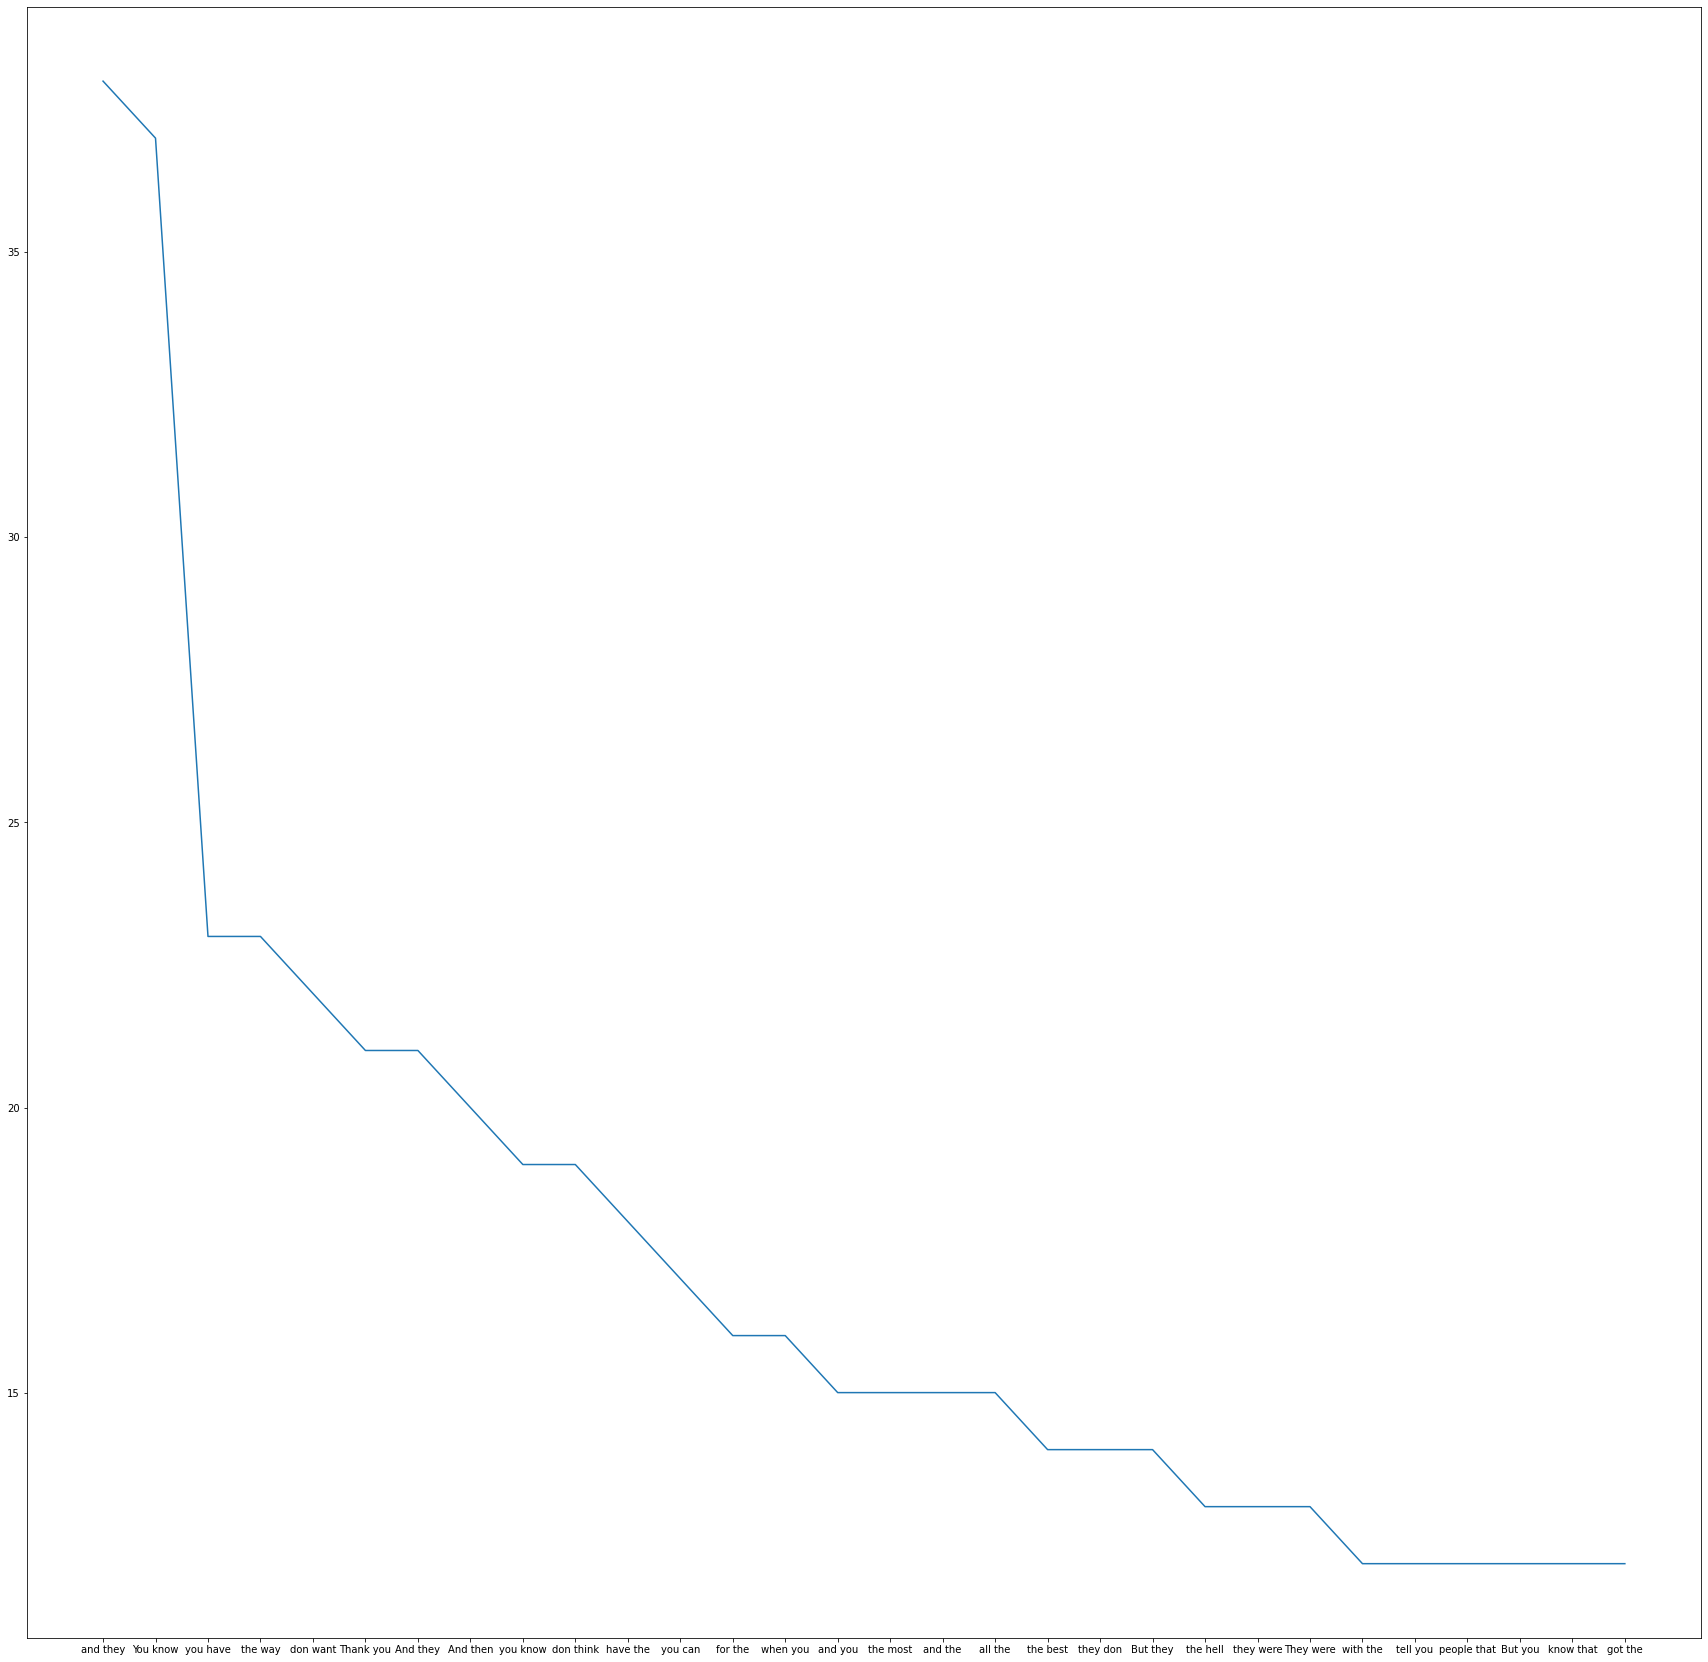

In [117]:
#plot bigram frequency
plt.figure(figsize=(30,30))
plt.plot(bigram,count)
plt.show()